In [2]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import pickle
import os
import sys
from osgeo import ogr
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from scipy.optimize import minimize
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  
import glob
import time




sys.path.insert(1, '../../modules')
# hand made functions
from Rouss1 import *
from Rouss2 import *
from Rouss3D import *

sys.path.insert(1,"../../Model_val/upscalling/")
from upscalling_functions import*

In [3]:
model_dir = "working"
model_name = "test_3D"
exe_name= "../../exe/mf6"

In [4]:
R_path="../../data/shp/limiteModeleRoussillon_poly.shp" # path to the shp of the aquifer

#rivers paths
Agly_path = "../../data/Fleuves/Agly_ludo.shp" # path to Agly
Tet_path = "../../data/Fleuves/Tet_ludo.shp"
Rea_path = "../../data/Fleuves/Reart_ludo.shp"
Tech_path = "../../data/Fleuves/Tech_ludo.shp"
Bol_path = "../../data/Fleuves/Boules_ludo.shp"
Cant_path = "../../data/Fleuves/Cant_ludo.shp"

#stations paths
Agly_stations = "../../data/Fleuves/stations_agly.csv" 
Tet_stations = "../../data/Fleuves/stations_tet2.csv"
Rea_stations = "../../data/Fleuves/stations_reart.csv"
Tech_stations = "../../data/Fleuves/stations_tech.csv"
Bol_stations = "../../data/Fleuves/stations_bol.csv"
Cant_stations = "../../data/Fleuves/stations_cant.csv"

#MPS and up


In [5]:
#spatial parameters

MNT_path = "../../data/surfaces_geoter/TOPO  (0 en mer).ASC"
x0,y0,x1,y1 = get_MNTbbox(MNT_path)

Lx = x1-x0
Ly = y1-y0
nlay = 3
res = 300

ncol = int(Lx/res)
nrow = int(Ly/res)

delr = np.ones(ncol)*res
delc = np.ones(nrow)*res

idomain = np.zeros((nrow*ncol))

grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0) # create a grid identical to the dis package, will be used
                                                                   # to pre-process data

In [28]:
# load dis infos
top,botm,idomain = read_pickle(os.path.join(model_dir,"export_dis3D"))

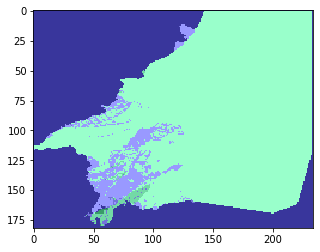

In [34]:
# a little plot
#idomain[idomain==0]=None
plt.imshow(idomain[1],alpha=0.4,cmap="bone")
plt.imshow(idomain[2],alpha=0.4,cmap="hot")
plt.imshow(idomain[0],alpha=0.4,cmap="winter")

In [35]:
# Do a list of all active cells
lst_domain = []
for ilay in range(nlay):
    for irow in range(nrow):
        for icol in range(ncol):
            if idomain[ilay,irow,icol] == 1:
                lst_domain.append((ilay,irow,icol))


In [36]:
#uppermost active cell
Up_cells_act = up_act_cell(idomain)

In [108]:
# BC sea
# import the shapefile that correspond to the BC
BCsea_path = "../../data/shp/sea_bc_extended.shp"
BC_sea = gp.read_file(BCsea_path)

# extract cellids from the BC at the sea and make these cells active
lst_chd = gp2cellids3D(grid,BC_sea,idomain,type="polygon",idomain_active=True)

# attribute a constant head at all the cells in the lst_chd
CHD = 0; chd_lst=[];
for x in lst_chd:
    chd_lst.append((x,-0.025*top[x[1],x[2]]))

In [46]:
# BC etangs
BCetangs_path = "../../data/shp/Surface_hydro/SURFACE_HYDROGRAPHIQUE.shp"
Bcet = gp.read_file(BCetangs_path)
etangs = Bcet[(Bcet["TOPONYME"]=="étang de canet") | (Bcet["TOPONYME"]=="étang de leucate")]

# extract cellids from the BC 
etangs_chd = gp2cellids3D(grid,etangs.dissolve(by="NATURE"),idomain,idomain_active=True)

# attribute a constant head
CHD = 0; et_chd_lst=[];
for x in etangs_chd:
    et_chd_lst.append((x,CHD))
    lst_chd.append(x)

In [48]:
Agy_chd = Complete_riv(Agly_path,Agly_stations,28,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Tech_chd = Complete_riv(Tech_path,Tech_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Cant_chd = Complete_riv(Cant_path,Cant_stations,140,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Rea_chd = Complete_riv(Rea_path,Rea_stations,100,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Tet_chd = Complete_riv(Tet_path,Tet_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Bol_chd = Complete_riv(Bol_path,Bol_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)

C:\Users\emmal\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [50]:
# extraction
path = "../../data/prélèvements/BD_FORAGES_SMNPR/SMNPRV2.shp"

stress_data_well = importWells3D(path,grid,lst_domain,V_col="V_A_AEMRC", geol_col="NAPPE_CAPT",
                                 geol_layer=["PLIOCENE","QUATERNAIRE"],layer_num=[1,0])

In [51]:
#permea
k = 5e-5

In [54]:
# control piezos
piez_path="../../data/piezos/pz_hydriad.xlsx"

#import the data using this function (path,modelgrid, sheetname of the data,piezometric level column, x and y coor (in L93 !))
geol_layer = ["Quaternaire","Pliocène"]
layer_num = [0,1]
geol_col = "AquifèreCapté"
Control_pz = ImportControlPz3D(piez_path,sheet_name="1990",geol_layer=geol_layer,layer_num=[0,1],geol_col=geol_col,
                               grid=grid,nlay=nlay)

C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [60]:
#recharge
rch_path = "../../data/recharge/rast_peff2.tif"
rcha = import_rch(rch_path,grid)

rch_lst=[]
for icell in Up_cells_act:
    ilay = icell[0]
    irow = icell[1]
    icol = icell[2]
    rch_lst.append(((icell),rcha[irow,icol]/1000/365/86400))
            
        

In [111]:
# basic modules

sim = fp.mf6.MFSimulation(sim_name='first3D_mf6', version='mf6', exe_name=exe_name, 
                         sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)

tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity="complex")


# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf,strt=botm+1)


# output control
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'ALL')],
                            printrecord=[('BUDGET', 'ALL')])


# nodeflowproperty
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=k, save_flows=True,save_specific_discharge=True)


# recharge
#rch  = fp.mf6.ModflowGwfrcha(gwf, recharge = rcha/1000/365/86400)
rch = fp.mf6.ModflowGwfrch(gwf,maxbound=len(rch_lst),stress_period_data=rch_lst)


chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='sea', filename="sea.chd", maxbound=len(chd_lst), 
                                               stress_period_data={0: chd_lst}, save_flows=True)

etangs = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='eta', filename="eta.chd", maxbound=len(et_chd_lst), 
                                               stress_period_data={0: et_chd_lst}, save_flows=True)

Riv1 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='agy', filename="agy.chd", maxbound=len(Agy_chd), 
                                              stress_period_data={0: Agy_chd}, save_flows=True)

Riv2 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Tet', filename="Tet.chd", maxbound=len(Tet_chd), 
                                               stress_period_data={0: Tet_chd}, save_flows=True)

Riv3 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Rea', filename="Rea.chd", maxbound=len(Rea_chd), 
                                               stress_period_data={0: Rea_chd}, save_flows=True)

Riv6 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Cant', filename="Cant.chd", maxbound=len(Cant_chd), 
                                               stress_period_data={0: Cant_chd}, save_flows=True)

Riv4 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Tech', filename="Tech.chd", maxbound=len(Tech_chd), 
                                               stress_period_data={0: Tech_chd}, save_flows=True)

Riv5 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Bol', filename="Bol.chd", maxbound=len(Bol_chd), 
                                               stress_period_data={0: Bol_chd}, save_flows=True)


In [112]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model test_3D...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rch_0...
    writing package sea...
    writing package eta...
    writing package agy...
    writing package tet...
    writing package rea...
    writing package cant...
    writing package tech...
    writing package bol...
FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, t

(False, [])

In [114]:
# retrieve heads and spdis 
head = get_heads(model_name,model_dir)
spdis = get_spdis(model_name,model_dir)

# retrieve the chd package name
bdfile=[]
for file in os.listdir(model_dir):
    if file.endswith(".chd"):
        bdfile.append(os.path.splitext(file)[0])

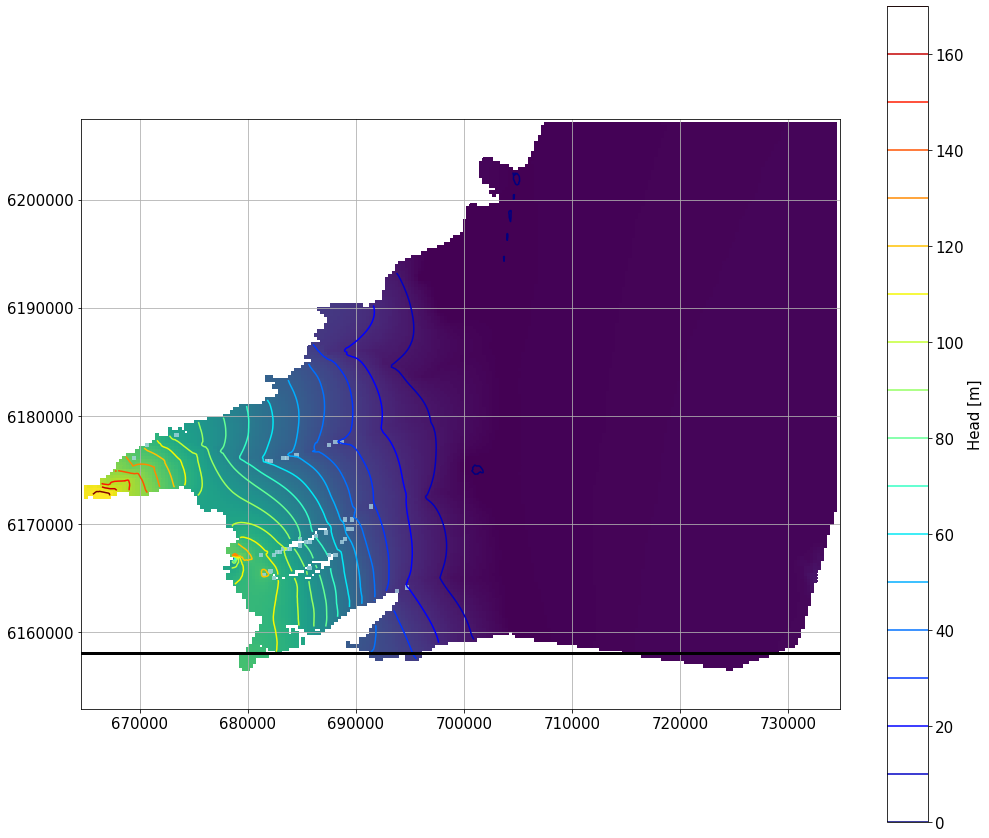

In [129]:
# make a plot
fig = plt.figure(figsize=(17,15))
layer = 1
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf,layer=layer)



hmesh=ml.plot_array(head[layer],masked_values=[0,1e30],cmap="viridis")
hmesh.set_clim(0,170)
#ml.plot_specific_discharge(spdis[0],color="w",width=0.0050)
cont=ml.contour_array(head[layer],masked_values=[0,1e30],levels=np.linspace(0,170,18),cmap="jet")

# plot bc
for bc in bdfile:
    if bc == ("sea") or bc== ("eta"):
        ml.plot_bc(bc,color="b",alpha=0.5)
    else : 
        ml.plot_bc(bc,color="lightblue",alpha=0.5)


# plot Cross-section
row = 165
x = [x0,x1]
y = [y1-(row+.5)*delc,y1-(row+.5)*delc]
ax.plot(x,y,"k",linewidth=3)


ax.tick_params(labelsize=15)
#ax.tick_params(axis="y",direction="in", pad=-120)

g = plt.colorbar(cont)
g.set_label("Head [m]",fontsize=15)
g.ax.tick_params(labelsize=15)

ax.grid()


(-200, 400)

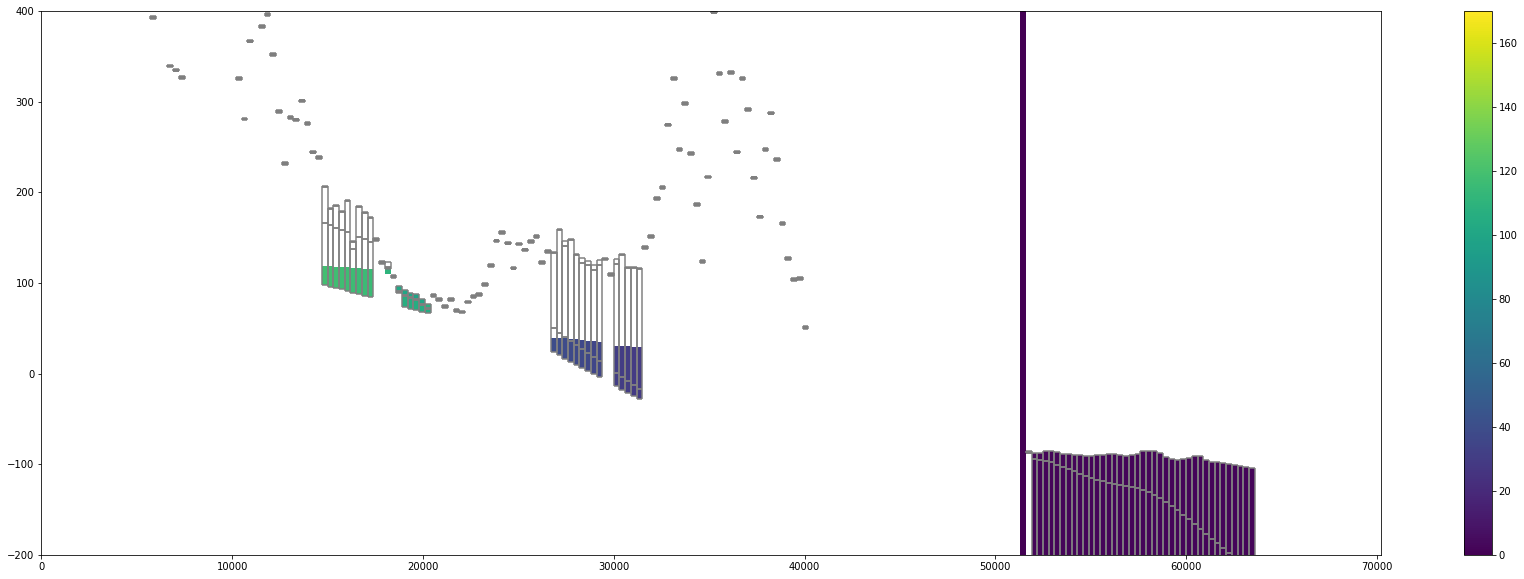

In [128]:
fig,ax = plt.subplots(figsize=(30,10))
x=fp.plot.PlotCrossSection(gwf,line={"row" :row})

arr=x.plot_array(head,masked_values=[1e30],head=head)
plt.colorbar(arr)
arr.set_clim(0,170)
x.plot_ibound()
x.plot_grid()
ax.set_ylim(-200,400)

In [124]:
# Total Budget
lstBudgetfile = "{}.lst".format(model_name)
fname = os.path.join(model_dir,lstBudgetfile)
Budgetobj = fp.utils.Mf6ListBudget(fname)

In [125]:
for i in Budgetobj.entries:
    if i != "PERCENT_DISCREPANCY":
        print("{} : {} m3/s".format(i,Budgetobj.get_budget(names=i)[0][0][-1]))

RCH_IN : 2.824399948120117 m3/s
CHD_IN : 0.6834999918937683 m3/s
TOTAL_IN : 6.7947001457214355 m3/s
RCH_OUT : 0.0 m3/s
CHD_OUT : 0.07191500067710876 m3/s
TOTAL_OUT : 6.793600082397461 m3/s
IN-OUT : 0.0011677000438794494 m3/s
